In [ ]:
# !jupyter nbconvert --to script pack_existing_segs.ipynb

In [ ]:
import einops
import os

import matplotlib.pyplot as plt
import numpy as np
from tianshou.policy import PPOPolicy
import uuid
from tianshou.utils import WandbLogger, LazyLogger
from torch.utils.tensorboard import SummaryWriter
from gymnasium.wrappers import TimeLimit
from customs import CustomDQNPolicy, CustomOffpolicyTrainer, CustomSubprocVectorEnv
from dataset import *
from env.env import *
from networks.qnet import *
from networks.vit import ViTTrailEncoder
from networks.SimpleAC import Actor as SimpleActor, Critic as SimpleCritic
from tianshou.utils.net.common import ActorCritic
from tianshou.utils.net.discrete import Actor, Critic, IntrinsicCuriosityModule
from tianshou.trainer import OnpolicyTrainer
import torch
import tianshou as ts
from networks.AC import MulActor, CAAdjCritic, CrossAttentionActor, CrossAttentionCritic, AdjExcludeCAC, AdjCrossAttentionActor, AdjCAAEnd, AdjCAC
from networks.path_vit import BaseNetwork as MulBaseNetwork
import torch.nn.functional as F
import random
from networks.simmim import BaseNetwork as SimmimBase
from networks.beit import BaseNetwork as BeitBase
from networks.mae import BaseNetwork as MaeBase, OrderEmbeddingBaseNetwork as OrdMaeBase
import utils
from utils import get_wandb
from pytorch_memlab import MemReporter


# reporter = MemReporter()

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
if __name__ == '__main__':
    wandb_logger = None
if '__file__' in globals():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    # device = 'cpu'
if '__file__' in globals() and __name__ == '__main__':
    torch.multiprocessing.set_start_method('spawn')

In [ ]:
class TrainFunction:
    def init(self, policy=None, eps_train=None, train_phases=None, trainer=None):
        self.policy = policy
        self.eps_train = eps_train
        self.train_phases = train_phases
        self.trainer = trainer

    def __call__(self, epoch, env_step):
        if self.eps_train:
            self.policy.set_eps(self.eps_train[epoch - 1])

        # if epoch >= self.train_phases[1]:
        #     policy = self.policy
        #     for param in policy.actor.preprocess.vit.encoder.layer[-6:].parameters():
        #         param.requires_grad = True
        #     for param in policy.actor.preprocess.vit.layernorm.parameters():
        #         param.requires_grad = True
        # if epoch >= self.train_phases[0]:
        #     policy = self.policy
        #     policy.actor.preprocess.vit.embeddings.order_embeddings.requires_grad = True
        if wandb_logger.use_wandb and epoch >= 0 and wandb_logger.wandb_run.step % 500 == 0:
            torch.save(self.policy.state_dict(),
                       f'saved/policy_{wandb_logger.wandb_run.name}_{wandb_logger.wandb_run.step}.pt')

        wandb_logger.write(
            'train', self.trainer.env_step, {"epoch": epoch})

In [ ]:
def get_DQN_policy(config):
    config.update({
        "n_step": 1,
        "target_freq": 1200,
    })

    action_count = len(Actions)
    net = Q_network(action_count).to(device)
    optim = torch.optim.Adam(net.parameters(), lr=config['lr'])
    policy = CustomDQNPolicy(net, optim, discount_factor=config['gamma'], estimation_step=config['n_step'],
                             target_update_freq=config['target_freq'], polyak=None)
    # register_hooks(policy.model)
    return policy


def get_PPO_policy(config):
    config.update({
        "gae_lambda": 0.95,
        "gae_batch_size": config['batch_size'],
        "max_grad_norm": 0.5,
        "vf_coef": 0.25,
        "ent_coef": .0001,
        "rew_norm": False,
        "eps_clip": 0.1,
        "value_clip": False,
        "dual_clip": 3,
        "norm_adv": False,
        "recompute_adv": False,
    })

    # old base, built-in actor and critic
    # base_net = ViTTrailEncoder().to(device)
    # actor = Actor(base_net, len(Actions), device=device, softmax_output=False, hidden_sizes=[])
    # critic = Critic(base_net, device=device, hidden_sizes=[])

    # old base, SimpleAC
    # base_net = ViTTrailEncoder().to(device)
    # actor = SimpleActor(base_net, len(Actions), device=device, softmax_output=False, hidden_sizes=[256])
    # critic = SimpleCritic(base_net, device=device, hidden_sizes=[512])

    # new base, built-in actor and critic
    # base_net = MulBaseNetwork(config['env_patch_size']).to(device)
    # actor = Actor(base_net, len(Actions), device=device, softmax_output=False)
    # critic = Critic(base_net, device=device)

    # new base, SimpleAC
    # base_net = MulBaseNetwork(config['env_patch_size']).to(device)
    # actor = SimpleActor(base_net, len(Actions), device=device, softmax_output=False, hidden_sizes=[256, 256])
    # critic = SimpleCritic(base_net, device=device, hidden_sizes=[512, 512])

    # new base, mulAC
    # base_net = MulBaseNetwork(config['env_patch_size']).to(device)
    # actor = MulActor(base_net.vit.config.hidden_size, base_net).to(device)
    # critic = MulCritic(base_net.vit.config.hidden_size, base_net).to(device)

    # simmim base, mulAC
    # base_net = SimmimBase(config['env_patch_size']).to(device)
    # actor = MulActor(base_net.vit.config.hidden_size, base_net).to(device)
    # critic = MulCritic(base_net.vit.config.hidden_size, base_net).to(device)

    # beit base, SimpleAC
    # base_net = BeitBase(config['env_patch_size'], False).to(device)
    # actor = SimpleActor(base_net, len(Actions), device=device, softmax_output=False, hidden_sizes=[256, 256])
    # critic = SimpleCritic(base_net, device=device, hidden_sizes=[512, 512])

    # beit base, mulAC
    # base_net = BeitBase(config['env_patch_size'], False).to(device)
    # actor = MulActor(base_net.vit.config.vocab_size, base_net).to(device)
    # critic = MulCritic(base_net.vit.config.vocab_size, base_net).to(device)

    # mae base, SimpleAC
    # base_net = MaeBase(config['env_patch_size'],
    #                    config['n_last_positions']).to(device)
    # actor = SimpleActor(base_net, len(Actions), device=device,
    #                     softmax_output=False, hidden_sizes=[1024, 1024])
    # critic = SimpleCritic(base_net, device=device, hidden_sizes=[2048, 2048])
    # actor = SimpleActor(base_net, len(Actions), device=device,
    #                     softmax_output=False, hidden_sizes=[256, 256])
    # critic = SimpleCritic(base_net, device=device, hidden_sizes=[512, 512])
    # head_ord_emb_params = [base_net.vit.embeddings.order_embeddings] + \
    #     list(actor.last.parameters()) + list(critic.last.parameters())
    # pretrained_params = list(
    #     base_net.vit.encoder.layer[-6:].parameters()) + list(base_net.vit.layernorm.parameters())
    # optim1 = torch.optim.Adam(
    #     head_ord_emb_params, lr=config['lr'], eps=1e-5
    # )
    # optim2 = torch.optim.Adam(
    #     pretrained_params, lr=config['ft_lr'], eps=1e-5
    # )

    # base_net = OrdMaeBase(config['env_patch_size'],
    #                       config['n_last_positions']).to(device)
    # actor = CrossAttentionActor(base_net, base_net.output_dim).to(device)
    # critic = CrossAttentionCritic(base_net, base_net.output_dim).to(device)

    # base_net = OrdMaeBase(config['env_patch_size'],
    #                       config['n_last_positions']).to(device)
    # actor = AdjCrossAttentionActor(base_net, base_net.output_dim).to(device)
    # critic = AdjExcludeCAC(base_net, base_net.output_dim).to(device)

    # base_net = OrdMaeBase(config['env_patch_size'],
    #                       config['n_last_positions']).to(device)
    # actor = AdjCAAEnd(base_net, base_net.output_dim).to(device)
    # critic = AdjExcludeCAC(base_net, base_net.output_dim).to(device)
    
    base_net = OrdMaeBase(config['env_patch_size'],
                          config['n_last_positions']).to(device)
    actor = AdjCAAEnd(base_net, base_net.output_dim).to(device)
    critic = AdjCAC(base_net, base_net.output_dim).to(device)

    # class OptimizerWrapper:
    #     def __init__(self, *optims):
    #         self.optims = optims

    #     def zero_grad(self):
    #         for optim in self.optims:
    #             optim.zero_grad()

    #     def step(self):
    #         for optim in self.optims:
    #             optim.step()
    # optim = OptimizerWrapper(optim1, optim2)

    optim = torch.optim.Adam(
    ActorCritic(actor, critic).parameters(), lr=config['lr'], eps=1e-5, 
    betas=[.9, .9]
    )

    def dist(p):
        return torch.distributions.Categorical(logits=p)

    # policy = PPOPolicy(
    policy = TempPPO(
        actor=actor,
        critic=critic,
        optim=optim,
        dist_fn=dist,
        discount_factor=config['gamma'],
        gae_lambda=config['gae_lambda'],
        max_grad_norm=config['max_grad_norm'],
        vf_coef=config['vf_coef'],
        ent_coef=config['ent_coef'],
        reward_normalization=config['rew_norm'],
        action_scaling=False,
        eps_clip=config['eps_clip'],
        value_clip=config['value_clip'],
        dual_clip=config['dual_clip'],
        advantage_normalization=config['norm_adv'],
        recompute_advantage=config['recompute_adv'],
        max_batchsize=config['gae_batch_size'],
    ).to(device)
    return policy

In [ ]:
from typing import Any, List, Dict
from tianshou.data import Batch
from tianshou.data import Batch, ReplayBuffer, to_torch_as

sample_batch = None


class TempPPO(PPOPolicy):
    def __init__(
        self, *args, **kwargs: Any,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.max_rew_mean = -np.inf
        self.prev_max_filename = None
    
    def process_fn(
        self, batch: Batch, buffer: ReplayBuffer, indices: np.ndarray
    ) -> Batch:
        global sample_batch
        sample_batch = batch.copy()
        if self._recompute_adv:
            # buffer input `buffer` and `indices` to be used in `learn()`.
            self._buffer, self._indices = buffer, indices
        batch = self._compute_returns(batch, buffer, indices)
        batch.act = to_torch_as(batch.act, batch.v_s)
        with torch.no_grad():
            batch.logp_old = self(batch).dist.log_prob(batch.act)
        return batch

    def learn(  # type: ignore
            self, batch: Batch, batch_size: int, repeat: int, **kwargs: Any
    ) -> Dict[str, List[float]]:
        losses, clip_losses, vf_losses, ent_losses = [], [], [], []
        for step in range(repeat):
            if self._recompute_adv and step > 0:
                batch = self._compute_returns(
                    batch, self._buffer, self._indices)
            for i, minibatch in enumerate(batch.split(batch_size, merge_last=True)):
                # calculate loss for actor
                self.actor.preprocess.store_output = True
                dist = self(minibatch).dist
                
                # print(torch.cuda.memory_summary())

                if self._norm_adv:
                    mean, std = minibatch.adv.mean(), minibatch.adv.std()
                    minibatch.adv = (minibatch.adv -
                                     mean) / (std + self._eps)  # per-batch norm
                ratio = (dist.log_prob(minibatch.act) -
                         minibatch.logp_old).exp().float()
                ratio = ratio.reshape(ratio.size(0), -1).transpose(0, 1)
                surr1 = ratio * minibatch.adv
                surr2 = ratio.clamp(
                    1.0 - self._eps_clip, 1.0 + self._eps_clip
                ) * minibatch.adv
                if self._dual_clip:
                    clip1 = torch.min(surr1, surr2)
                    clip2 = torch.max(clip1, self._dual_clip * minibatch.adv)
                    clip_loss = - \
                        torch.where(minibatch.adv < 0, clip2, clip1).mean()
                else:
                    clip_loss = -torch.min(surr1, surr2).mean()
                # calculate loss for critic
                
                value = self.critic(minibatch.obs).flatten()

                if (step==0 or step==repeat-1) and wandb_logger.use_wandb:
                    rew_min, rew_max, rew_mean, rew_std = minibatch.rew.min(
                    ), minibatch.rew.max(), minibatch.rew.mean(), minibatch.rew.std()
                    adv_min, adv_max, adv_mean, adv_std = minibatch.adv.min().cpu().item(), minibatch.adv.max().cpu().item(), minibatch.adv.mean().cpu().item(), minibatch.adv.std().cpu().item()
                    ret_min, ret_max, ret_mean, ret_std = minibatch.returns.min().cpu().item(), minibatch.returns.max().cpu().item(), minibatch.returns.mean().cpu().item(), minibatch.returns.std().cpu().item()
                    pred_ret_min, pred_ret_max, pred_ret_mean, pred_ret_std = value.min().cpu().item(), value.max().cpu().item(), value.mean().cpu().item(), value.std().cpu().item()
                    pred_ret_of_min, pred_ret_of_max = value[minibatch.returns.argmin()].cpu().item(), value[minibatch.returns.argmax()].cpu().item()
                    # residual_var = ((minibatch.returns - value).var() / minibatch.returns.var()).cpu().item()
                    value_corr = torch.corrcoef(torch.vstack([minibatch.returns, value]))[0, 1].cpu().item()
                    rel_entropy = dist.entropy().mean().cpu().item()/(torch.distributions.Categorical(logits=torch.ones(len(Actions))).entropy())
                    
                    effective_pos_adv_ratio = (((ratio<1.0 + self._eps_clip) & (minibatch.adv>0)).sum()/(minibatch.adv>0).sum()).cpu().item()
                    effective_neg_adv_ratio = (((ratio>1.0 - self._eps_clip) & (ratio < self._dual_clip) & (minibatch.adv<0)).sum()/(minibatch.adv<0).sum()).cpu().item()
                    pos_adv_mean = minibatch.adv[minibatch.adv>0].mean().cpu().item()
                    neg_adv_mean = minibatch.adv[minibatch.adv<0].mean().cpu().item()
                    
                    wandb_logger.wandb_run.log({
                        'reward/min': rew_min,
                        'reward/max': rew_max,
                        'reward/mean': rew_mean,
                        'reward/std': rew_std,
                        'advantage/min': adv_min,
                        'advantage/max': adv_max,
                        'advantage/mean': adv_mean,
                        'advantage/std': adv_std,
                        'return/min': ret_min,
                        'return/max': ret_max,
                        'return/mean': ret_mean,
                        'return/std': ret_std,
                        'predicted_return/min': pred_ret_of_min,
                        'predicted_return/max': pred_ret_of_max,
                        'predicted_return/mean': pred_ret_mean,
                        'predicted_return/std': pred_ret_std,
                        'residual_var': value_corr,
                        'rel_entropy': rel_entropy,
                        'effective_pos_adv_ratio': effective_pos_adv_ratio,
                        'effective_neg_adv_ratio': effective_neg_adv_ratio,
                        'pos_adv_mean': pos_adv_mean,
                        'neg_adv_mean': neg_adv_mean,
                    })
                if wandb_logger.use_wandb and minibatch.rew.mean() > self.max_rew_mean:
                    self.max_rew_mean = rew_mean
                    filename = f'saved/policy_max_{wandb_logger.wandb_run.name}_{wandb_logger.wandb_run.step}.pt'
                    torch.save(self.state_dict(), filename)
                    if self.prev_max_filename:
                        try:
                            os.remove(self.prev_max_filename)
                        except:
                            pass
                    self.prev_max_filename = filename

                if self._value_clip:
                    v_clip = minibatch.v_s + \
                        (value - minibatch.v_s).clamp(-self._eps_clip, self._eps_clip)
                    vf1 = (minibatch.returns - value).pow(2)
                    vf2 = (minibatch.returns - v_clip).pow(2)
                    vf_loss = torch.max(vf1, vf2).mean()
                else:
                    vf_loss = (minibatch.returns - value).pow(2).mean()
                # calculate regularization and overall loss
                ent_loss = dist.entropy().mean()
                loss = clip_loss + self._weight_vf * vf_loss \
                    - self._weight_ent * ent_loss
                self.optim.zero_grad()
                
                loss.backward()
                
                if self._grad_norm:  # clip large gradient
                    nn.utils.clip_grad_norm_(
                        self._actor_critic.parameters(), max_norm=self._grad_norm
                    )
                self.optim.step()
                
                clip_losses.append(clip_loss.item())
                vf_losses.append(vf_loss.item())
                ent_losses.append(ent_loss.item())
                losses.append(loss.item())

        return {
            "loss": losses,
            "loss/clip": clip_losses,
            "loss/vf": vf_losses,
            "loss/ent": ent_losses,
        }

In [ ]:
def get_offpolicy_trainer(policy, config, wandb_logger, train_fn):
    replay_buffer = ts.data.VectorReplayBuffer(
        config['buffer_size'], len(config['train_envs']))
    train_collector = ts.data.Collector(
        policy, config['train_envs'], replay_buffer, exploration_noise=True)

    config.update({
        "eps_start": 0.9,
        "eps_end": 0.05,
        'update_per_step': 1 / config['step_per_collect'] * 4,
        "eps_train": np.linspace(0.9, 0.05, 2000),
        "eps_test": 0,
    })
    trainer = CustomOffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=None,
        episode_per_test=1,  # dummy
        max_epoch=config['epoch'],
        step_per_epoch=config['step_per_epoch'],
        step_per_collect=config['step_per_collect'],
        batch_size=config['batch_size'],
        update_per_step=config['update_per_step'],
        train_fn=train_fn,
        test_fn=lambda epoch, env_step: policy.set_eps(config['eps_test']),
        logger=wandb_logger,
    )
    return trainer


def get_onpolicy_trainer(policy, config, wandb_logger, train_fn):
    replay_buffer = ts.data.VectorReplayBuffer(
        config['buffer_size'],
        len(config['train_envs']),
    )
    train_collector = ts.data.Collector(
        policy, config['train_envs'], replay_buffer, exploration_noise=True)
    test_collector = ts.data.Collector(policy, config['test_envs'])

    config['train_envs'].mix_envs([0, 1, 2, 3], config['env_step_limit'])

    config.update({
        'repeat_per_collect': 5,
    })

    trainer = OnpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=config['epoch'],
        step_per_epoch=config['step_per_epoch'],
        repeat_per_collect=config['repeat_per_collect'],
        batch_size=config['batch_size'],
        step_per_collect=config['step_per_collect'],
        episode_per_test=config['episode_per_test'],
        train_fn=train_fn,
        logger=wandb_logger,
    )

    return trainer

In [88]:
if __name__ == "__main__":  # Policy Initialization########
    _bs = 900
    _envs = 50
    _steps = _bs * 1
    config = {
        "lr": 3e-4,
        "ft_lr": 2e-5,
        "epoch": 2000,
        "batch_size": _bs,
        "train_phases": [],
        "gamma": 0.98,
        "buffer_size": _steps,
        "env_step_limit": 500,
        "env_step_limit_test": 200,
        "env_step_mem": None,
        "env_patch_size": (16, 16),
        'num_train_envs': _envs,
        'step_per_collect': _steps,
        "step_per_epoch": 5 * _steps,
        'n_last_positions': 20,
        'episode_per_test': 5,
    }

    dataset_test = COCODataset(train=False, length=config['episode_per_test'], no_seg=False, fix_resize=(224-3*16, 224-3*16), SAMseg=False) 
    # dataset = COCODataset(train=True, indices=[12], no_seg=False, fix_resize=(224-3*16, 224-3*16))
    dataset = COCODataset(train=True, length=3000, no_seg=False, fix_resize=(224-3*16, 224-3*16), SAMseg=False)
    

    def env_creator():
        torch.manual_seed(os.getpid())
        return TimeLimit(
            Environment(
                dataset, config['env_patch_size'], max_len=config['env_step_mem'], n_last_positions=config['n_last_positions']),
            config['env_step_limit'])

    train_envs = CustomSubprocVectorEnv(
        [env_creator for _ in range(config['num_train_envs'])])
    config['train_envs'] = train_envs
    config['test_envs'] = ts.env.DummyVectorEnv(
        [lambda: TimeLimit(Environment(dataset_test, config['env_patch_size'], max_len=config['env_step_mem'], n_last_positions=config['n_last_positions']),
                           config['env_step_limit_test']) for _ in range(1)])

    # policy = get_DQN_policy()
    policy = get_PPO_policy(config)
    
    if '__file__' not in globals(): #notebook
        print(policy.load_state_dict(torch.load("./saved/policy_eternal-river-241_4000.pt", map_location=device)))
        pass
    else: # run
        # print(policy.load_state_dict(torch.load("./saved/policy_dark-durian-213_9000.pt", map_location=device)))
        pass

<All keys matched successfully>


In [ ]:
# policy = torch.compile(policy)
torch.set_float32_matmul_precision('high')
torch.set_printoptions(precision=4, sci_mode=False)

In [ ]:
if __name__ == "__main__":  # TTTTTTTTTTTTTTTTTTTTTTTTTTTraining########
    # if '__file__' in globals():
    use_wandb = True
    wandb_logger = get_wandb(use_wandb)

    # trainer = get_offpolicy_trainer(policy)
    train_fn = TrainFunction()
    trainer = get_onpolicy_trainer(policy, config, wandb_logger, train_fn)
    train_fn.init(
        policy, None, config['train_phases'], trainer)

    if use_wandb:
        wandb_logger.wandb_run.config.update(config)

    # with torch.autograd.set_detect_anomaly(True):
    trainer.run()

Box(children=(Output(), Output()))

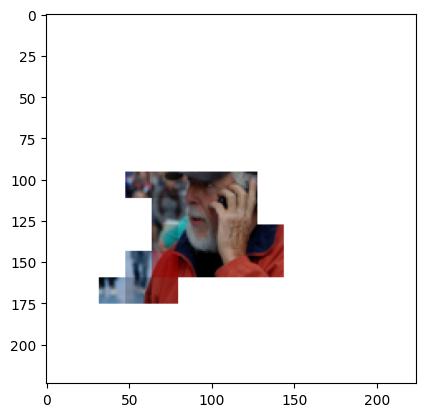

In [98]:
import ipywidgets as widgets
import IPython.display as display

if __name__ == "__main__" and '__file__' not in globals():
    display.clear_output(wait=True)
    seg_out = widgets.Output()
    img_out = widgets.Output()
    stat_out = widgets.Output()
    box = widgets.Box(children=[img_out, seg_out])
    display.display(box)

    policy.eval()

    ''' 
    test time modifications
    '''
    fa = None
    def test_dist_fn(logits):
        global fa
        probs = nn.functional.softmax(logits).squeeze().cpu().numpy()
        if fa is None:
            fa = plt.subplots(figsize=(2, 2))
            plt.figure(figsize=(2,2))
            fa[1].set_xlim([-1,1])
            fa[1].set_ylim([-1,1])
            fa[1].quiver([0,0,0,0], [0,0,0,0], [0, probs[1], 0, -probs[3]], [probs[0], 0, -probs[2], 0], scale=1)
        else:
            fa[1].get_children()[0].set_UVC([0, probs[1], 0, -probs[3]], [probs[0], 0, -probs[2], 0])
        display.display(fa[0])
        input()
        # return torch.distributions.Categorical(probs=torch.distributions.transforms.SoftmaxTransform()(logits.pow(4)))
        return torch.distributions.Categorical(logits=logits)
    # policy.dist_fn = test_dist_fn
    # policy.set_eps(config['eps_test'])
    ''''''

    dataset = COCODataset(train=True, indices=[
                          69], no_seg=False, fix_resize=(224-3*16, 224-3*16))
    env = TimeLimit(Environment(dataset,
                                config['env_patch_size'],
                                max_len=config['env_step_mem'],
                                n_last_positions=config['n_last_positions']
                                ),
                    # config['env_step_limit_test']
                    500
                    )
    collector = ts.data.Collector(policy, env, exploration_noise=False)

    with seg_out:
        utils.show_masks_on_image(einops.rearrange(
            env.unwrapped.current_image, 'c h w -> h w c'), env.unwrapped.current_seg.cpu().numpy())
    with img_out:
        collector.collect(n_episode=1, render=1 / 300)
        # collector.collect(n_step=1, render=1 / 5)